# LHP Construction with Duration matching

We can easily match a liability if we had a zero coupon bond that had the exact maturity as the liability, in which case, assuming we had enough funds available, we could do perfect cash flow matching.


We'll use a portfolio of standard, non-coupon bonds to try and achieve the same behaviour as a zero coupon bond.

In order to do this, we'll have to find a way to price a bond. A bond is nothing more than a series of cash flows that the issuer is offering to make to you, and therefore, the price of a bond is nothing more than the present value of the future cash flows.

To be more precise, we should use discount rates matching the payment horizons using the yield curve. For simplicity, we'll assume that the yield curve is flat, and the rate of interest is the same regardless of whether it is 1 year, 5 year, 10 year or 30 year horizon. We'll also assume that bonds pay a monthly coupon thereby avoiding some of the complexities of intra-coupon payment. 

In [9]:
import numpy as np
import pandas as pd
import kit  as erk
import math

In [2]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year

    coupon_times = np.arange(1, n_coupons+1)

    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment


    return cash_flows
                                            
def bond_price(maturity = 10 , principal=100, coupon_rate=0.03, coupons_per_year = 12, discount_rate = 0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return erk.pv(cash_flows, discount_rate/coupons_per_year)

## Macaulay Duration

Consider the following chart that shows the change in value of a bond for interest rates from 2% to 10%. The bond in question is a 10 year bond that pays a 5% coupon semiannually and the face value is $1000.

<Axes: title={'center': 'Change in Bond Prices by Interest Rates'}>

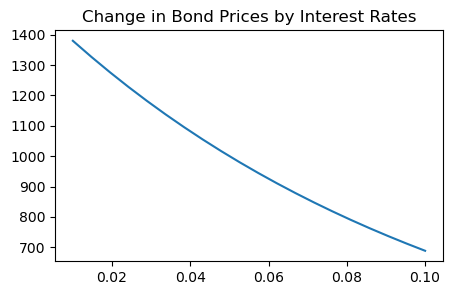

In [8]:
rates = np.linspace(.01, .10, num=20)
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]

pd.DataFrame(data=prices, index=rates).plot(title="Change in Bond Prices by Interest Rates", legend=False, figsize= (5,3) )

Assume that we have a liability of \$1000 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall. If we had a Zero Coupon bond, we could purchase that, but Zero Coupon bonds of specific maturities arent always available.

<br>

What is available are various bonds with maturities from 5 to 30 years. If they both respond the same way to changes in interest rates, we can effectively obtain immunity to interest rate changes.

<br>


One way to do this is through **Duration Matching**. The duration of a bond measures its senstivity to interest rate changes. Therefore, we match the duration of the liabilities to the duration of the bond portfolio. As it happens, the duration of a bond which is computed as the weighted average time of the cash flows, weighted by the cash flows.
This is the **Macaulay Duration** which is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back.
Thus the *Duration of a Zero Coupon bond* is just the maturity, since there is a single cash flow at maturity.

<br>

You can also compute something called the _Modified Duration_ which gives you a more direct measure of how much the bond price will move for a small change in interest rates (i.e. the first derivative of the bond price with respect to interest rates). However, we won't need to compute that since the Macaulay Duration is itself a measure of sensitivity and all we need to do is to match that to our liability.

In [26]:
flows = pd.DataFrame( erk.bond_cash_flows(3, 1000, 0.06, 2) )
discount_bond_price = erk.discount(flows.index, 0.06/2) 
discounted_flows = (discount_bond_price*flows)

print( flows, discount_bond_price, discounted_flows, sep = '\n\n' )

        0
1    30.0
2    30.0
3    30.0
4    30.0
5    30.0
6  1030.0

          0
1  0.970874
2  0.942596
3  0.915142
4  0.888487
5  0.862609
6  0.837484

            0
1   29.126214
2   28.277877
3   27.454250
4   26.654611
5   25.878264
6  862.608784


In [40]:
dates = pd.DataFrame(flows.index)
w = discounted_flows/discounted_flows.sum()
avg = np.average(dates, weights = w)

print( f'{avg:.3f} periods (6 months)' )

5.580 periods (6 months)


In this example, we'll need to wait about 5.58/2 = 2.79 years on average to get back the present value of the bond.

```python
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights = weights)
```

In [8]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

## Duration Matching

Assume we have a liability of $\$100 K$ in 10 years time and another of $\$100K$ in 12 years time. Assume interest rates are 4%. 

What is the duration of the liabilities?


In [47]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])
print( f'{erk.macaulay_duration(liabilities, 0.04):.2f}' )

10.96


Now assume we have two types of bonds available. We have a 10 year bond and a 20 year bond. Each of them pays a 5% coupon once a year and has a face value of $\$1000$.

What are the durations of these bonds?

In [46]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), 0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), 0.04)


print( f'{md_10:.2f}    {md_20:.2f}' )

8.19    13.54


Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \cdot 8.19 + (1-w_s) \cdot  13.54 = 10.96  \:\;, \quad w_l = 1 - w_s $$

more generally

$$ w_s\cdot  d_s + (1-w_s)\cdot  d_l = d_t$$

Rearranging gives

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$


<br>

Implementing it.

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)

    w_s = (d_l - d_t)/(d_l - d_s)

    return w_s, 1-w_s
```

```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and present value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```


In [58]:
short_bond = pd.DataFrame( erk.bond_cash_flows(10, 1000, 0.05, 1) )
price_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)


long_bond = pd.DataFrame( erk.bond_cash_flows(20, 1000, 0.05, 1) )
price_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)


w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_l = 1 - w_s


a_0 = 130000            # No. bonds           returns flow
dm_assets = pd.concat( [a_0*w_s/price_short  * short_bond,   a_0*w_l/price_long  * long_bond] )



print( f'{erk.macaulay_duration(liabilities, 0.04):.2f}' )
print( f'{erk.macaulay_duration(dm_assets, 0.04):.2f}' )

10.96
10.96


In [68]:
fr = erk.funding_ratio(dm_assets, liabilities, 0.04).values[0]

print( f'We are {fr*100:.3f}% covereded' )

We are 99.988% covereded


---

In [ ]:
lb_assets = a_0*long_bond/price_long
sb_assets = a_0*short_bond/price_short

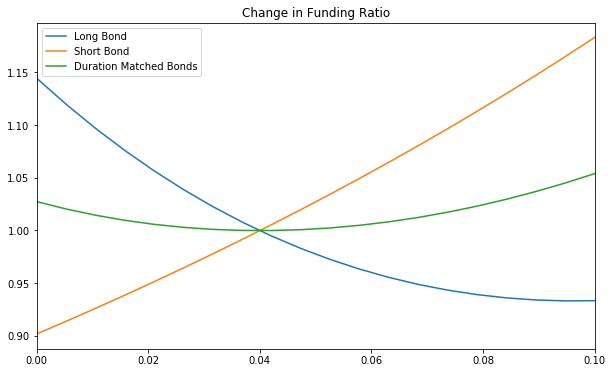

In [24]:
rates = np.linspace(0, .1, 20)
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(dm_assets, liabilities, r) for r in rates]
}, index=rates)


fr_change.plot(title='Change in Funding Ratio', figsize=(10,6))

### Conclusion

We've seen that if we have the assets on hand, one can secure future liabilities by matching the duration of liabilities with the durations of assets to immunize yourself against level shifts in the yield curve. In practice, one might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that one will have the money to meet the liabilities when interest rates fluctuate.